In [11]:
%load_ext autoreload 
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
from fusanet_utils.datasets.simulated import SimulatedPoliphonic
from fusanet_utils.datasets.fusa import FUSA_dataset
from torch.utils.data import ConcatDataset
from tqdm.notebook import tqdm
import yaml
import json

categories = json.load(open('/home/phuijse/Downloads/index_to_name.json'))
model = torch.load('/home/phuijse/Downloads/model.pt')
dataset = SimulatedPoliphonic('..', external=True, mini=False, categories = (categories.values()))
params = yaml.safe_load(open('../experiments/Poliphonic-PANN-sed-no-pretrained/params.yaml'))
fusa_dataset = FUSA_dataset(ConcatDataset([dataset]), feature_params=params["features"])

len(dataset.categories)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


33

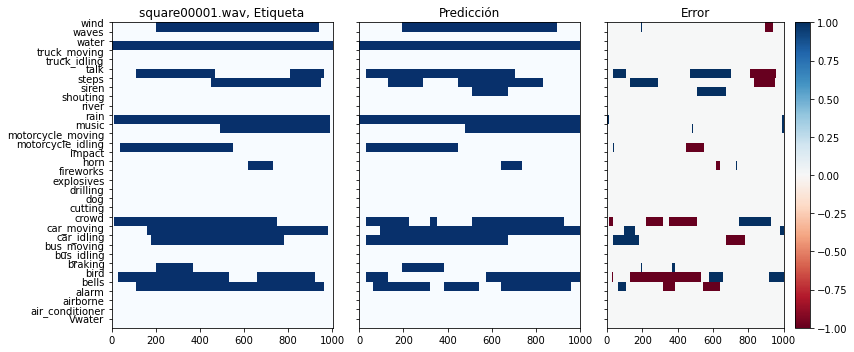

In [44]:
def plot_file_prediction(file_idx: int, th: float=None):
    pred = model.forward(fusa_dataset[file_idx])[0].T.detach().numpy()
    if th is not None:
        pred = pred > th
    label = fusa_dataset[file_idx]['label'].T.numpy()
    fig, ax = plt.subplots(1, 3, figsize=(12, 5), facecolor='w',
                           tight_layout=True, sharex=True, sharey=True)
    ax[0].pcolormesh(label, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[0].set_title(f"{fusa_dataset[file_idx]['filename']}, Etiqueta")
    ax[1].pcolormesh(pred, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[1].set_title('Predicción')
    cmap = ax[2].pcolormesh((pred - label), cmap=plt.cm.RdBu, vmin=-1, vmax=1)
    fig.colorbar(cmap)
    ax[2].set_title('Error')
    ax[0].set_yticks(range(1, len(categories.values())+1))
    ax[0].set_yticklabels((categories.values()));
    
plot_file_prediction(0, 0.3)

In [65]:
scenarios = ['square', 'park', 'waterfront', 'market', 'street']
th = 0.3
errors, places = [], []
for sample in tqdm(fusa_dataset):
    places.append([scene for scene in scenarios if scene in sample['filename']][0])
    pred = model.forward(sample)[0].T.detach().numpy() > th
    label = sample['label'].T.numpy()
    errors.append(pred - label) 

  0%|          | 0/25 [00:00<?, ?it/s]

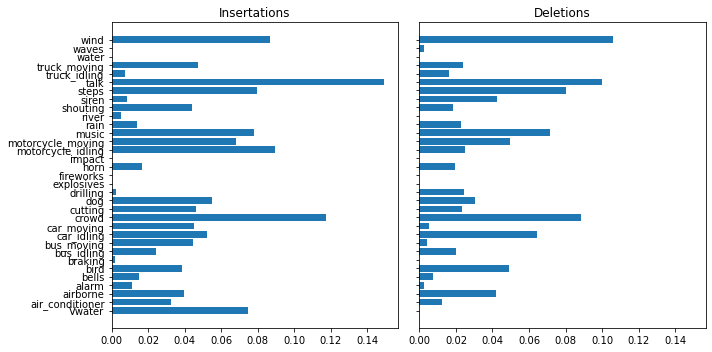

In [66]:
n_windows = sum([error.shape[1] for error in errors])
insertions = np.sum(np.stack([np.sum(error > 0, axis=1) for error in errors]), axis=0)
deletions = np.sum(np.stack([np.sum(error < 0, axis=1) for error in errors]), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, sharey=True, sharex=True)
ax[0].barh(y=list(categories.values()), width=insertions/n_windows)
ax[0].set_title('Insertations')
ax[1].barh(y=list(categories.values()), width=deletions/n_windows)
ax[1].set_title('Deletions');